# SVM Classification with TF-IDF

This notebook demonstrates how to perform text classification using Support Vector Machines (SVM) and TF-IDF feature extraction.
Target Label: `Label`
Content: `Cleaned_Content`

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load the dataset
file_path = '../cleaned_data.csv'
data = pd.read_csv(file_path)

# Display the first few rows
data.head()

,Content,Paper Name,Label,Cleaned_Content
0,Insulin resistance is a condition characterize...,Brain insulin resistance mediated cognitive im...,Alzheimer's Disease,insulin resistance condition characterized att...
1,substrate 1 (IRS1)/PI3K/AKT and IGF-1 receptor...,Brain insulin resistance mediated cognitive im...,Alzheimer's Disease,substrate irs pi akt igf receptor igf irs pi p...
2,Prolactin is a pituitary anterior lobe hormone...,Hyperprolactinemia and Brain Health: Exploring...,Alzheimer's Disease,prolactin pituitary anterior lobe hormone play...
3,Lecanemab is an amyloid-targeted antibody indi...,Severe Persistent Urinary Retention Following ...,Alzheimer's Disease,lecanemab amyloid targeted antibody indicated ...
4,Glycoprotein 88 (GP88) is a secreted biomarker...,An Impedimetric Immunosensor for Progranulin D...,Alzheimer's Disease,glycoprotein gp secreted biomarker overexpress...


In [3]:
# Check for missing values
print("Missing values before drop:")
print(data[['Label', 'Cleaned_Content']].isnull().sum())

# Drop rows with missing values in 'Cleaned_Content' or 'Label'
data = data.dropna(subset=['Label', 'Cleaned_Content'])

print("\nShape after dropping missing values:", data.shape)

Missing values before drop:
Label              0
Cleaned_Content    0
dtype: int64

Shape after dropping missing values: (1641, 4)


In [4]:
# Initialize TF-IDF Vectorizer
# max_features is set to 5000 to limit the number of features, you can adjust this
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the 'Cleaned_Content' column
X = tfidf_vectorizer.fit_transform(data['Cleaned_Content'])
y = data['Label']

print("Shape of TF-IDF matrix:", X.shape)

Shape of TF-IDF matrix: (1641, 5000)


In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

Training set size: 1312
Testing set size: 329


In [6]:
# Initialize the SVM classifier
# kernel='linear' is generally good for high-dimensional text data
svm_classifier = SVC(kernel='linear', random_state=42)

# Train the classifier
svm_classifier.fit(X_train, y_train)
print("Model training completed.")

Model training completed.


In [7]:
# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6748

Classification Report:
                         precision    recall  f1-score   support

    Alzheimer's Disease       0.66      0.70      0.68        71
Frontotemporal Dementia       0.94      0.65      0.77        77
     Lewy Body Dementia       0.56      0.52      0.54        60
    Parkinson's Disease       0.58      0.71      0.64        59
      Vascular Dementia       0.68      0.79      0.73        62

               accuracy                           0.67       329
              macro avg       0.68      0.67      0.67       329
           weighted avg       0.70      0.67      0.68       329



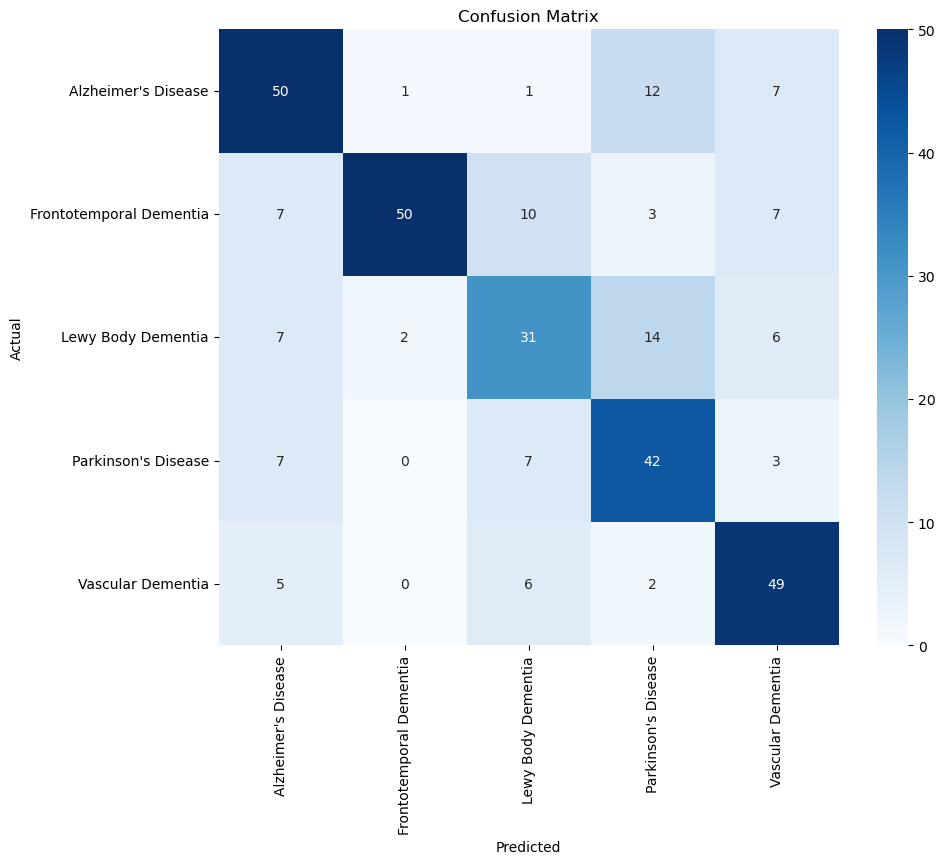

In [8]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=svm_classifier.classes_, yticklabels=svm_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()